# Queue model

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Wed_light.csv', index_col=0)

In [3]:
df.head()

,hour:minute,wlan.sa,wlan.da,wlan.ssid
0,11:01,00:f6:63:81:c8:6b,ff:ff:ff:ff:ff:ff,55546775657374
2,11:01,50:ed:3c:13:d7:4d,00:f6:63:81:c8:6f,NaN
4,11:01,00:f6:63:81:c8:6e,ff:ff:ff:ff:ff:ff,4775657374
31,11:01,50:ed:3c:13:d7:4d,00:f6:63:81:c8:6f,NaN
33,11:01,00:f6:63:81:c8:6f,ff:ff:ff:ff:ff:ff,656475726f616d


In [4]:
# filter by ssid
df = df[df["wlan.ssid"] == "656475726f616d"] #eduroam

In [5]:
df_first = df.drop_duplicates(subset='wlan.sa', keep='first')
df_last = df.drop_duplicates(subset='wlan.sa', keep='last')
print(df_first["wlan.sa"].nunique())
print(df_last["wlan.sa"].nunique())

1662
1662


In [6]:
per_min_last=pd.DataFrame(df_last["hour:minute"].value_counts().sort_index())
per_min_new=pd.DataFrame(df_first["hour:minute"].value_counts().sort_index())

_5min_new = pd.DataFrame({'hour:minute':per_min_new.index.tolist(),'count': per_min_new["count"]})
_5min_new['hour:minute'] = pd.to_datetime(_5min_new['hour:minute'], format='%H:%M')
_5min_new['hour:minute'].dt.strftime('%H:%M')
_5min_new.set_index('hour:minute',inplace=True)
count_first_1min = _5min_new #.reset_index(drop=True, inplace=True)
#_5min_new_ = _5min_new.resample('5T').sum()
#print(count_first_1min)
_5min_last = pd.DataFrame({'hour:minute':per_min_last.index.tolist(),'count': per_min_last["count"]})
_5min_last['hour:minute'] = pd.to_datetime(_5min_last['hour:minute'], format="%H:%M")
_5min_last.set_index('hour:minute', inplace=True)
#last_per5min_ = _5min_last.resample('5T').sum()
#print(_5min_last.reset_index(drop=True, inplace=True))
count_last_1min = _5min_last


In [7]:
df_minute = df.groupby('hour:minute')['wlan.sa'].nunique()


In [8]:

df_minute.head()

hour:minute
11:01    8
11:02    5
11:03    5
11:04    4
11:05    3
Name: wlan.sa, dtype: int64

In [21]:
s1 = count_first_1min[10:].stack()
s2 = df_minute[15:-1]

In [22]:
df_20 = pd.DataFrame({'enter_count':s1})
#df_20['enter_count'] = s2

In [24]:
df_20['total_count'] = s2.to_numpy()

In [25]:
df_20.head()

,,enter_count,total_count
hour:minute,,,
1900-01-01 11:16:00,count,4,8
1900-01-01 11:17:00,count,3,9
1900-01-01 11:18:00,count,1,9
1900-01-01 11:19:00,count,6,14
1900-01-01 11:20:00,count,3,8


In [26]:
df_20['enter_count'].sum()

1637

In [27]:
# Constants
nr_counters = 3
serving_speed = 5  # people per minute

# Initialize queue_count column
df_20['queue_count'] = 0

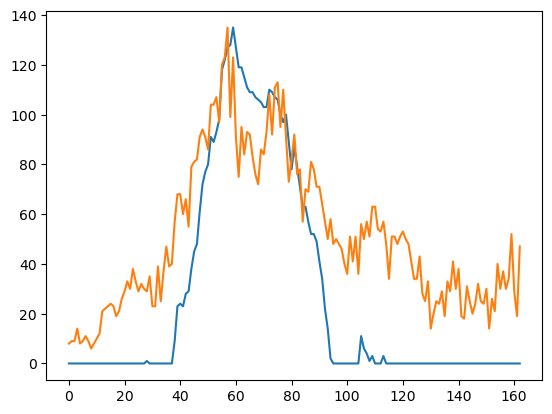

In [28]:
# Calculate queue count for each minute
for i in range(len(df_20)):
    #print(i)
    if i == 0: #timepoint 0
        df_20['queue_count'].iloc[i] = max(0, 0 + df_20['enter_count'].iloc[i] - nr_counters * serving_speed)
    else:
        df_20['queue_count'].iloc[i] = max(0, df_20['queue_count'].iloc[i-1] + df_20['enter_count'].iloc[i] - nr_counters * serving_speed)

    
#print(df_20)
plt.plot(df_20['queue_count'].to_numpy())
plt.plot(df_20['total_count'].to_numpy())
# important: data starts at 11:15 (bcs at the start we have some minutes with no new entries
